## Part 4

This part of the code provides the solution to exercise 4

In [1]:
# Data manipulation

import numpy as np
import pandas as pd 
from scipy.optimize import minimize
import matplotlib.pyplot as plt

df = pd.read_csv('DataPart4.csv')
df['U_a'] = df['Ph'] / (df['Ti'] - df['Te'])
print(df.head())

            Ph         Ti         Te         W         U_a
0  1496.970334  20.002530  12.255610  8.678768  193.234261
1  1411.792178  19.957051  12.298405  7.185271  184.339658
2  1368.595696  19.904727  12.576470  6.684292  186.755957
3  1404.547674  19.886161  12.455047  7.702868  189.009055
4  1376.436161  19.908530  12.638600  7.047383  189.332786


**Local polynomial regression**

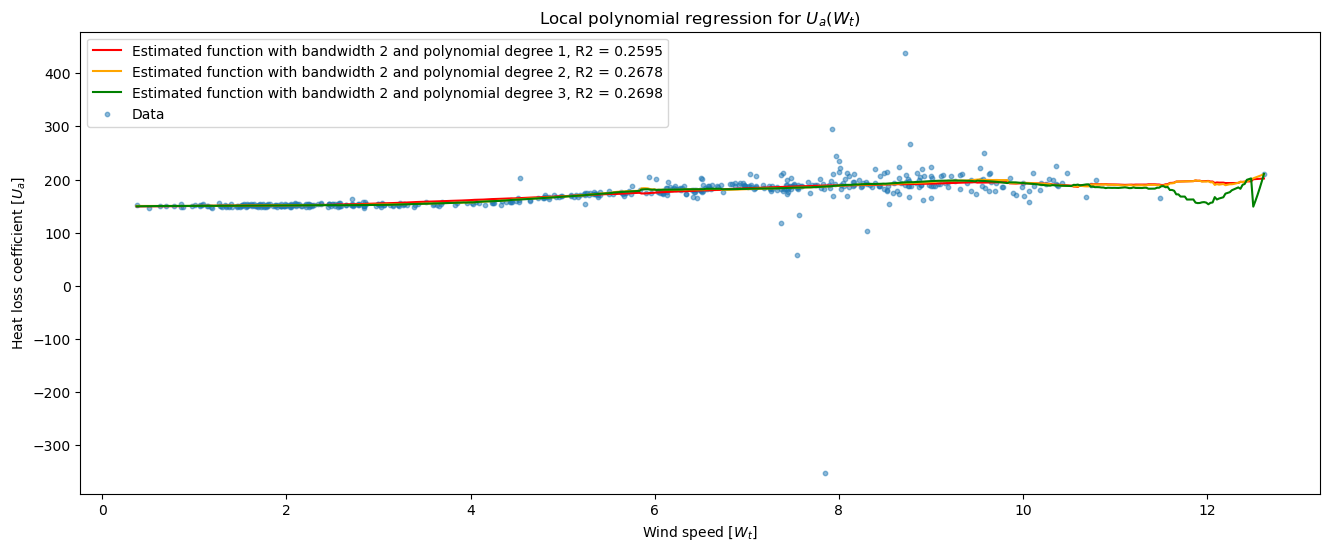

In [2]:
# Define the weight function
def kernel(x):
    return 1 / 2 * ((x >= -1) & (x <= 1)).astype(float)

# Get the interval that the function is estimated over
nr_data = len(df['U_a'])
w_span = np.linspace(min(df['W']), max(df['W']), nr_data) # Linear regression of the interval we are estimating the function in

# Define the loss function that we are trying to minimize
def loss(data, theta_params, w, h = 2): 
    # Define all the values that we want to minimize   
    return 1 / len(data) * sum(kernel((w - data['W']) / h ) * (
    (
    data['Ph'] / (data['Ti'] - data['Te']
    )
    ) - 
    theta((w - data['W']), theta_params)
    ) ** 2
    )

# Trial function
def least_squares(data, w, degree_of_polynomial, h = 2, opt = 'local_polynomial_regression'):
    if opt == 'varying_coefficient_model':
        X = (np.array(data['W'])[:, None] - w) ** np.arange(degree_of_polynomial + 1)
        Z = (data['Ti'] - data['Te']).values
        W = np.diag(kernel((w - data['W']) / h )) # Kernel weights
        Y = data['Ph'] / (data['Ti'] - data['Te'])
        print(f'Returns here')
        theta_opt = np.linalg.inv(Z @ X.T @ W @ X) @ Z @ X.T @ W @ Y


        return theta_opt
    else:
        X = (np.array(data['W'])[:, None] - w) ** np.arange(degree_of_polynomial + 1)
        W = np.diag(kernel((w - data['W']) / h )) # Kernel weights
        Y = data['Ph'] / (data['Ti'] - data['Te'])
        theta_opt = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ Y
        
        return theta_opt



# Define the varying parameters
def theta(w, theta_param):
    # Compute the powers of the polynomial
    powers = np.arange(len(theta_param))
    # Compute the polynomail variable terms, the difference
    w_powers = np.power.outer(w.values, powers)
    
    prod = np.dot(w_powers, theta_param)
    return pd.Series(prod) # Compute the sum of all polynomial terms

def optimization(polynomial_degree, w_span, data, h = 2, opt = 'local_polynomial_regression'):
    # theta_0 = np.zeros(polynomial_degree + 1)
    theta_params_all = []
    for w in w_span:

        # Optimization to find the local coefficients - switched from scipy opt to least squares and storing all the parameters
        theta_opt = least_squares(data, w, polynomial_degree, h, opt = opt)
        theta_params_all.append(theta_opt)
    return np.array(theta_params_all)

def part_4(Y_t, w_span, polynomial_degree = 3, h = 2, color = 'red', opt = 'local_polynomial_regression'):
    theta_params_all = optimization(polynomial_degree, w_span, df)    
    output_w = [theta_params_all[w_idx][0] for w_idx, _ in enumerate(w_span)]
    
    # Interpolation for 
    y_hat = np.interp(np.array(df['W']), w_span, output_w)
    ss_res = np.sum((Y_t - y_hat)**2)
    ss_tot = np.sum((Y_t - np.mean(Y_t))**2)
    R_2 = 1 - ss_res / ss_tot
    plt.plot(w_span, output_w, label=rf"Estimated function with bandwidth {h} and polynomial degree {polynomial_degree}, R2 = {R_2:.4f}", color = color)
    
plt.figure(figsize=(16, 6))
plt.title(rf'Local polynomial regression for $U_a(W_t)$')
p = 3
colors = ['blue', 'red', 'orange', 'green']
for pol_degree in range(1, p + 1):
    part_4(Y_t = np.array(df['U_a']), w_span = w_span, h = 2, polynomial_degree = pol_degree, color = colors[pol_degree])
plt.scatter(df['W'], (df['Ph'] / (df['Ti'] - df['Te'])), s = 10, alpha=0.5, label="Data")
plt.xlabel(rf'Wind speed [$W_t$]')
plt.ylabel(rf'Heat loss coefficient [$U_a$]')
plt.legend()
plt.show()

**Varying coefficient model**

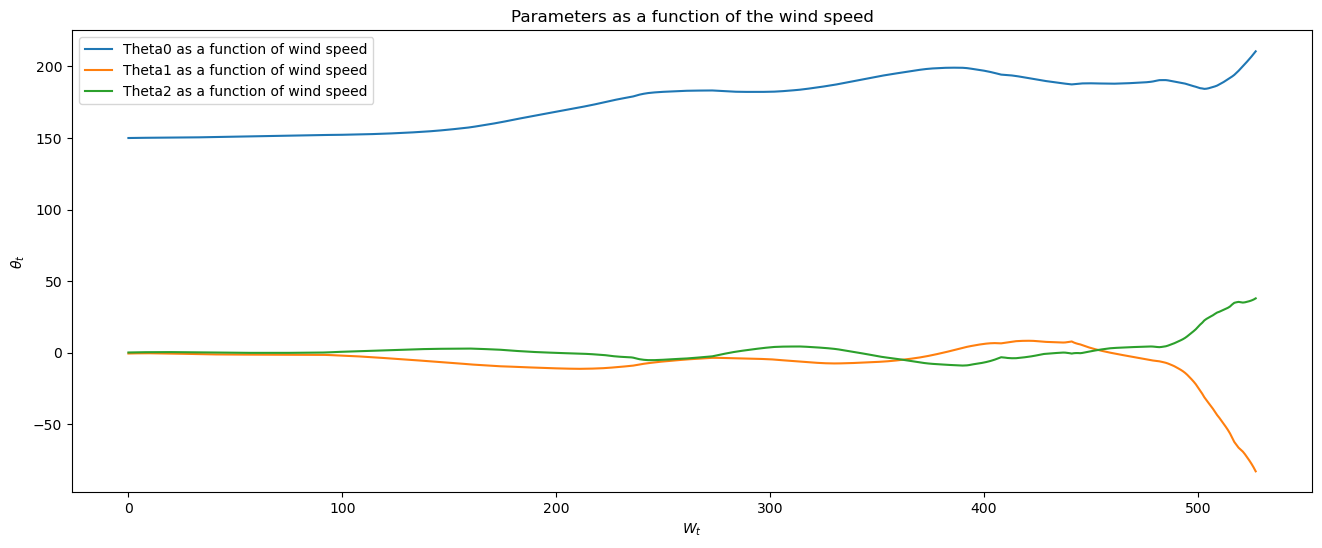

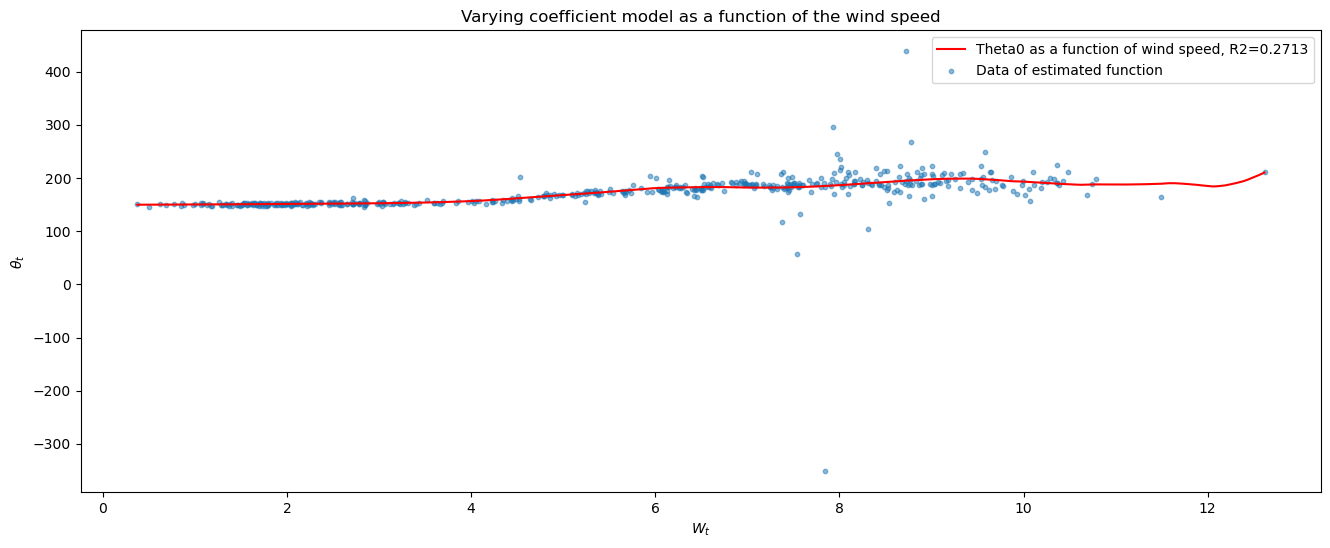

In [3]:
# Varying coefficient model

import numpy as np
from numpy.linalg import inv
from scipy.optimize import minimize_scalar

def epanechnikov(u): # Use the Epanechnikov kernel
    k = np.zeros_like(u)
    boolean_in_interval = np.abs(u) <= 1
    k[boolean_in_interval] = 0.75 * (1 - u[boolean_in_interval]**2)
    return k

def local_quadratic_estimates(W, y, w_grid, h, kernel = epanechnikov):
    # This function defines the least squares of local regression, the kernel regression by local polynomial regression
    N = len(W)
    thetas = np.zeros((len(w_grid), 3))
    for w_index, w in enumerate(w_grid):
        u = (w - W) / h
        weights = kernel(u) # Extract the weights from the kernel function

        X = np.column_stack([np.ones(N), (w - W), (w - W)**2]) # Define the design matrix
        WX = X * weights[:, None]   # weight the design matrix
        XtWX = X.T @ WX # define both terms for the matrix least squares problem
        XtWy = X.T @ (weights * y)
        beta = np.linalg.solve(XtWX, XtWy) # Find the coefficents
        thetas[w_index, :] = beta
    return thetas[:,0], thetas[:,1], thetas[:,2] # Return parameters for all three vectors

def loo_cv_bandwidth(W, y, w_grid, h_candidates, kernel=epanechnikov):
    # Define the loo problem to optimize bandwidth
    def cv_for_h(h):

        # Find the coefficients of the optimized problems 
        theta0, theta1, theta2 = local_quadratic_estimates(W, y, w_grid, h, kernel)
        preds = np.zeros(len(W)) # Initialize an empty list of predictions
        for W_index, Wi in enumerate(W):
            idx = np.argmin(np.abs(w_grid - Wi))
            b0, b1, b2 = theta0[idx], theta1[idx], theta2[idx]
            preds[W_index] = b0 + b1*(w_grid[idx] - Wi) + b2*(w_grid[idx] - Wi)**2
        
        return np.nanmean((y - preds)**2)

    # Minimize to find best bandwidth
    best_h = min(h_candidates, key = cv_for_h)
    return best_h

# Define the arrays of the wind speed and the deterministic part of the heat transfer coefficient so that we do not have to redo it for all usecases
W = np.array(df['W'])
y = np.array(df['Ph'] / (df['Ti'] - df['Te']))

# Define the interval that the function is being approximated on
w_grid = np.linspace(min(W), max(W), len(y))
h = 2  

# Find the local polynomial regression for weights
theta0, theta1, theta2 = local_quadratic_estimates(W, y, w_grid, h)
y_hat = np.interp(W, w_grid, theta0)

# Find the residual error and total error
ss_res = np.sum((y - y_hat)**2)
ss_tot = np.sum((y - np.mean(y))**2)

R_2 = 1 - ss_res / ss_tot
# Plot of parameter estimates
plt.figure(figsize=(16, 6))
plt.plot([i for i in range(len(theta0))], theta0, label = 'Theta0 as a function of wind speed')
plt.plot([i for i in range(len(theta1))], theta1, label = 'Theta1 as a function of wind speed')
plt.plot([i for i in range(len(theta2))], theta2, label = 'Theta2 as a function of wind speed')
plt.legend()
plt.title('Parameters as a function of the wind speed')
plt.xlabel(rf'$W_t$')
plt.ylabel(rf'$\theta_t$')
plt.show()

# Plot of the function estimate -- all evaluated in the same point as they are estimated in, hence theta0
plt.figure(figsize=(16, 6))
plt.plot(np.linspace(min(W), max(W), len(theta0)), theta0, label = f'Theta0 as a function of wind speed, R2={R_2:.4f}', color = 'red')
plt.scatter(W, y, alpha = 0.5, s = 10, label = 'Data of estimated function')
plt.legend()
plt.title('Varying coefficient model as a function of the wind speed')
plt.xlabel(rf'$W_t$')
plt.ylabel(rf'$\theta_t$')
plt.show()

